In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

from helper import load_countries, join_countries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = "../../data/"
counts_file = DATA_PATH+"mentions_counts_by_state_and_day_filtered_5themes.csv"

# Data loading and cleanup

We first load the file processed on the cluster that contain the counts of mentions for each days and countries and then join it with a the countries csv to get the real names and regions of them.

In [4]:
countries = load_countries(DATA_PATH)
counts = pd.read_csv(counts_file)
counts = join_countries(counts, countries, with_iso=True)
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.sample(10)

,GLOBAL_COUNT,ENV_COUNT,Country,Region,ISO,DATE,Ratio
4487,11708,402.0,Afghanistan,Asia,AF,2015-11-12,0.034335
160414,1880,9.0,Poland,Europe,PL,2016-10-18,0.004787
188383,21783,346.0,Syrian Arab Republic,Asia,SY,2016-10-13,0.015884
155736,347,8.0,South Sudan,Africa,SS,2016-01-10,0.023055
14145,1332,31.0,Austria,Europe,AT,2017-03-30,0.023273
137562,397,7.0,Malta,Europe,MT,2015-12-11,0.017632
202522,1040,28.0,Uganda,Africa,UG,2017-08-23,0.026923
32136,1350,44.0,Brazil,Americas,BR,2015-08-06,0.032593
13361,26734,1122.0,Australia,Oceania,AU,2016-10-18,0.041969
73105,82947,1583.0,France,Europe,FR,2015-11-18,0.019084


In [5]:
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,159326.000000,159326.000000,159326.000000
mean,4365.742974,157.029738,0.070047
std,21506.614650,1073.027103,0.124111
min,1.000000,1.000000,0.000048
25%,201.000000,6.000000,0.014658
50%,651.000000,20.000000,0.030769
75%,2334.000000,68.000000,0.067487
max,644499.000000,101530.000000,1.000000


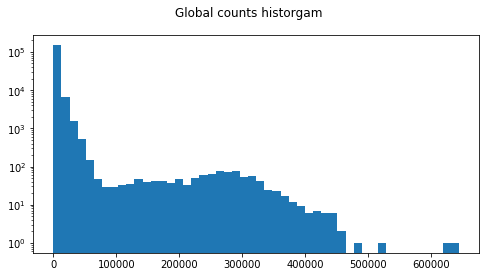

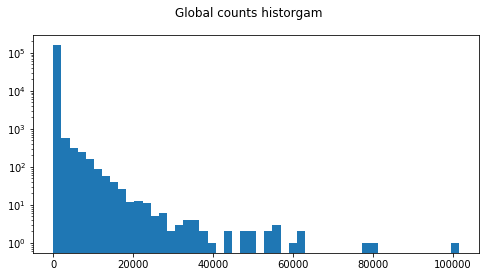

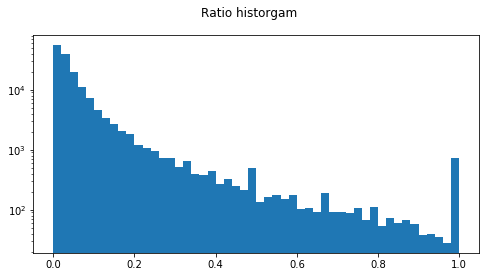

In [6]:
plt.figure(figsize=(8,4))
plt.suptitle("Global counts historgam")
plt.hist(counts.GLOBAL_COUNT, log=True, bins=50)

plt.figure(figsize=(8,4))
plt.suptitle("Global counts historgam")
plt.hist(counts.ENV_COUNT, log=True, bins=50)

plt.figure(figsize=(8,4))
plt.suptitle("Ratio historgam")
_ = plt.hist(counts.Ratio, log=True, bins=50)

### Cleanup
We have chosed to filter out the records where there was not enough mentions. We've done this with the folowing quantile test:

In [7]:
q_minus = counts.GLOBAL_COUNT.quantile(0.05)
print(f"5% quantile: {q_minus:0.2f}")
counts = counts[(counts.GLOBAL_COUNT>q_minus)]

5% quantile: 35.00


# Worldwide ratio

Text(0, 0.5, 'Ratio')

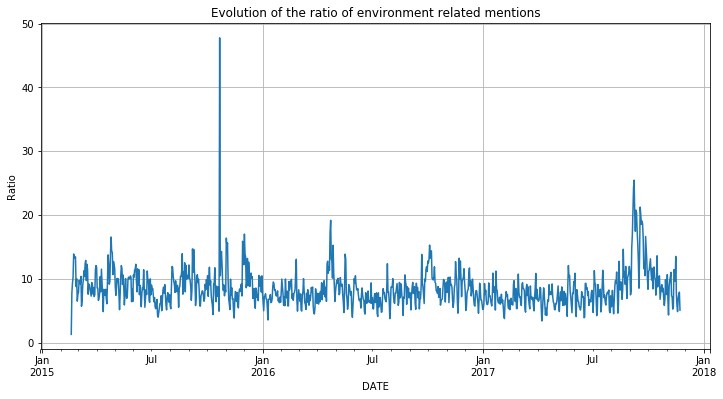

In [8]:
worldwide_ratio = counts.groupby(by=["DATE"]).sum().reset_index()
worldwide_ratio.assign(Ratio=worldwide_ratio.ENV_COUNT/worldwide_ratio.GLOBAL_COUNT)
ax = worldwide_ratio.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio")

In [9]:
worldwide_ratio[worldwide_ratio.Ratio>17.0].sort_values("Ratio", ascending=False)

,DATE,GLOBAL_COUNT,ENV_COUNT,Ratio
246,2015-10-22,72216,23473.0,47.772360
933,2017-09-08,680039,122085.0,25.485819
932,2017-09-07,704279,111418.0,24.318533
943,2017-09-18,669484,38210.0,21.267025
936,2017-09-11,654616,119215.0,20.793805
931,2017-09-06,759177,135435.0,20.650468
937,2017-09-12,757805,84618.0,20.370302
934,2017-09-09,418604,75470.0,20.219707
944,2017-09-19,815529,49488.0,20.057197
430,2016-04-23,512421,38080.0,19.195754


# Ratio by european countries
As we want display on a map the mean ratio for each european countries over the period of the dataset, we first need to remove outliers days for each countries.

We do this by first calculating the 1% and 99% quantiles of the ratio of environmental mentions for each countries separatly and the filter the days that are outisde this range countries by countries.

In [10]:
q_minus = counts[["ISO", "Ratio"]].groupby("ISO").quantile(0.01)
q_plus = counts[["ISO", "Ratio"]].groupby("ISO").quantile(0.99)
counts = counts.set_index("ISO")
counts = counts.merge(q_minus.rename(columns={"Ratio":"qm"}), left_index=True, right_index=True)
counts = counts.merge(q_plus.rename(columns={"Ratio":"qp"}), left_index=True, right_index=True)
counts = counts[(counts.Ratio>counts.qm) & (counts.Ratio<counts.qp)]
counts.drop(columns=["qm", "qp"], inplace=True)
counts.reset_index(inplace=True)

counts.to_csv(counts_file + ".NO_OULIERS.csv")

We can now recompute the ratio with the outliers removed

In [11]:
europe_counts = counts[counts.Region=="Europe"].groupby(["ISO"]).sum()
europe_counts = europe_counts.assign(Ratio=europe_counts.ENV_COUNT/europe_counts.GLOBAL_COUNT)
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(20)

,GLOBAL_COUNT,ENV_COUNT,Ratio
ISO,,,
GB,31313440,776812.0,0.024808
RU,22089465,644132.0,0.029160
FR,13934177,555842.0,0.039891
DE,9975518,235992.0,0.023657
IT,5346531,176656.0,0.033041
GR,4812925,105701.0,0.021962
ES,3723722,76255.0,0.020478
IE,3683417,61591.0,0.016721
BE,3655930,58449.0,0.015987


Now we have all the data necessary to create the map

In [12]:
import json
import folium
import pygeoj
import branca

In [13]:
geo_json_data = pygeoj.load(DATA_PATH + "europe.geojson")

In [14]:
results_map = folium.Map([49,15], tiles='cartodbpositron', zoom_start=4)

In [15]:
europe_counts = europe_counts.reset_index()

In [16]:
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 0.1)

In [17]:
def style_function(feature):
    value = europe_counts.loc[europe_counts['ISO']==feature['properties']['ISO2']].Ratio.values
    if(len(value)>0):
        value = value[0]
    else:
        value = None
    return {
        'fillOpacity': 0.6,
        'weight': 0,
        'fillColor': '#black' if value is None else colorscale(value)
    }

In [18]:
folium.GeoJson(
    geo_json_data,
    style_function=style_function
    ).add_to(results_map)

In [19]:
results_map.add_child(colorscale)